In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 获取当前目录
current_dir = os.getcwd()

# 添加 `interClusLib` 的上级目录到 Python 路径
sys.path.append(os.path.join(current_dir, ".."))

import interClusLib
from interClusLib.IntervalData import IntervalData
from interClusLib.metric import *
from interClusLib.clustering.IntervalKMeans import IntervalKMeans
from interClusLib.visualization.IntervalParallelCoordinates import IntervalParallelCoordinates
from interClusLib.visualization.IntervalRadarChart import IntervalRadarChart

print("interClusLib Path:", interClusLib.__file__)

random_data = random_data = IntervalData.make_interval_blobs(n_samples = 30, n_dims=4 ,n_clusters = 4)
print("\n Random Interval Data:")
print(random_data.data)
random_data.summary()

interClusLib Path: /Users/jiashuchen/Desktop/InterClusLib/examples/../interClusLib/__init__.py

 Random Interval Data:
    feature_1_lower  feature_1_upper  feature_2_lower  feature_2_upper  \
0          5.310792         6.564899         5.359311         8.056098   
1        -10.235861        -8.572472        -0.241687         2.495226   
2        -11.676909        -7.954812         1.461807         1.761455   
3         -8.705862        -6.443371         1.520689         3.010814   
4          6.145489         7.247619         3.087097         4.001663   
5         -9.527593        -6.562384         1.685011         2.840956   
6          4.134156         4.234156         6.172657         9.331511   
7         -9.621968        -6.886663        -0.946839         0.720132   
8         -9.277420        -8.514652         1.012181         3.445909   
9          5.534117         6.277843         5.267818         9.868875   
10       -10.995948        -7.381834        -0.631664         1.554

In [2]:
model = IntervalKMeans(n_clusters=4,max_iter=20,tol=1e-4,random_state=42)
model.fit(random_data.get_intervals())

print(model.labels_)

[1 3 2 2 0 2 1 2 3 1 2 3 2 3 3 0 1 3 0 1 3 0 1 2 3 0 0 0 0 1]


<Figure size 1500x800 with 0 Axes>

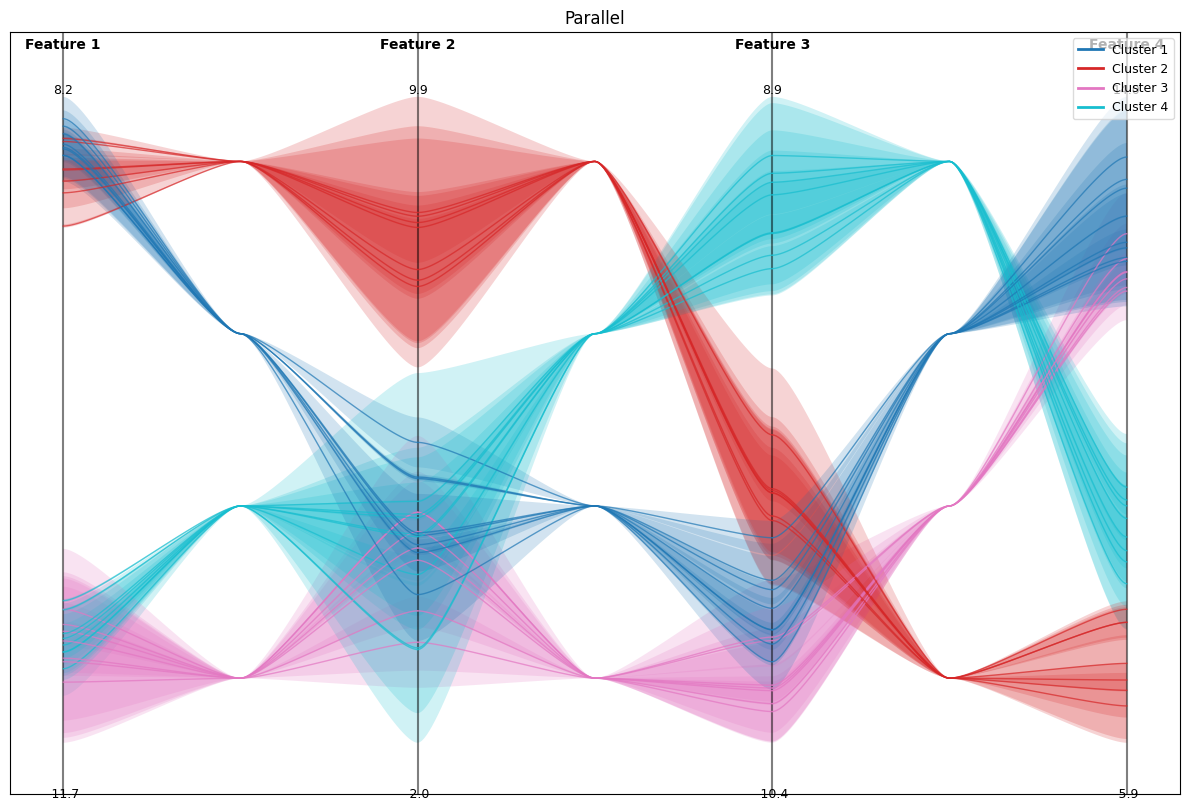

In [3]:
plt.figure(figsize=(15, 8))
IntervalParallelCoordinates.plot_interval_curves(data = random_data.get_intervals(), feature_names= None, clusters=model.labels_, beta=1)
plt.title("Parallel")
plt.show()

<Figure size 1500x800 with 0 Axes>

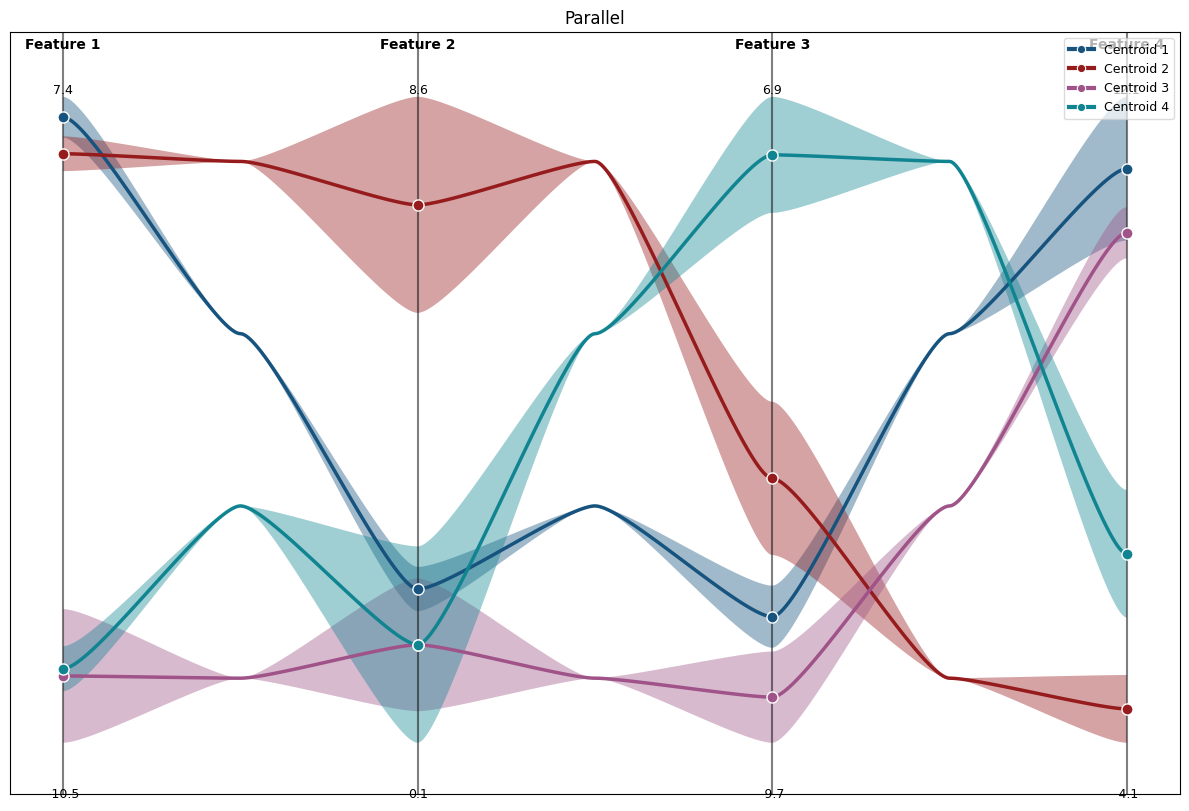

In [4]:
plt.figure(figsize=(15, 8))
IntervalParallelCoordinates.plot_interval_curves(data = None, feature_names= None, clusters=model.labels_, centroids = model.centroids_, beta = 1)
plt.title("Parallel")
plt.show()

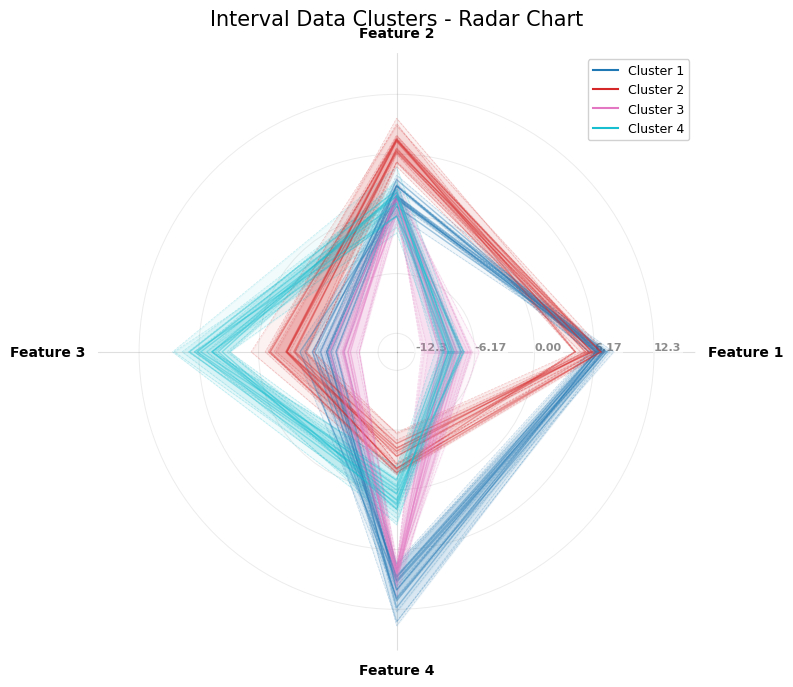

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

IntervalRadarChart.plot_interval_radar(
        data=random_data.get_intervals(), 
        feature_names=None, 
        clusters=model.labels_, 
        centroids=None, 
        ax=ax, 
        use_color=True,
        uncertainty_alpha=0.15
    )
    
plt.title('Interval Data Clusters - Radar Chart', size=15, pad=20)
plt.tight_layout()
plt.show()

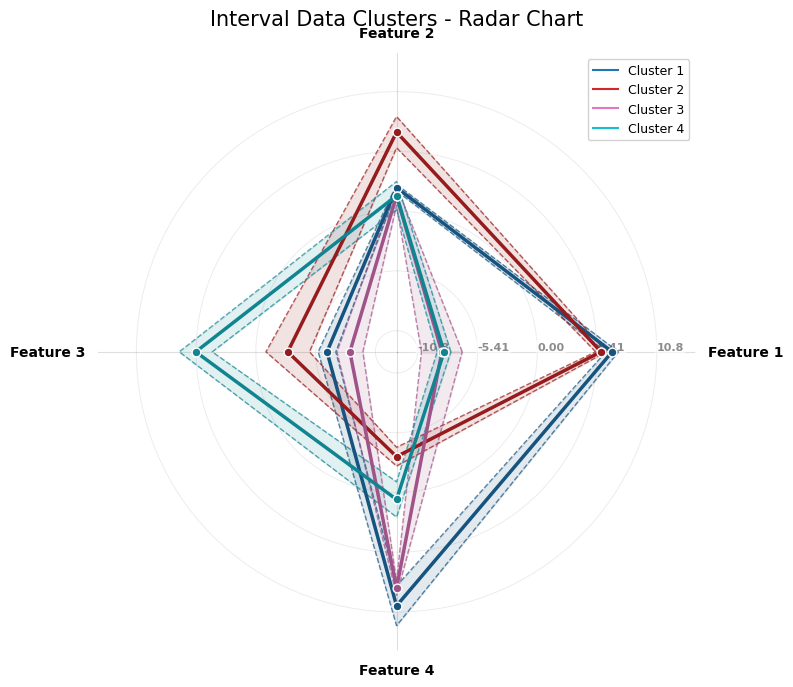

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

IntervalRadarChart.plot_interval_radar(
        data=None, 
        feature_names=None, 
        clusters=model.labels_, 
        centroids=model.centroids_, 
        ax=ax, 
        use_color=True,
        uncertainty_alpha=0.15
    )
    
plt.title('Interval Data Clusters - Radar Chart', size=15, pad=20)
plt.tight_layout()
plt.show()